<a href="https://colab.research.google.com/github/JoaoVictorNunes/JoaoVictorNunes/blob/main/btree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import bisect
import itertools
import operator

In [ ]:
class _BNode(object):
    __slots__ = ["tree", "contents", "children"]

    def __init__(self, tree, contents=None, children=None):
        self.tree = tree
        self.contents = contents or []
        self.children = children or []
        if self.children:
            assert len(self.contents) + 1 == len(self.children), \
                    "one more child than data item required"

    def __repr__(self):
        name = getattr(self, "children", 0) and "Branch" or "Leaf"
        return "<%s %s>" % (name, ", ".join(map(str, self.contents)))

    def lateral(self, parent, parent_index, dest, dest_index):
        if parent_index > dest_index:
            dest.contents.append(parent.contents[dest_index])
            parent.contents[dest_index] = self.contents.pop(0)
            if self.children:
                dest.children.append(self.children.pop(0))
        else:
            dest.contents.insert(0, parent.contents[parent_index])
            parent.contents[parent_index] = self.contents.pop()
            if self.children:
                dest.children.insert(0, self.children.pop())

    def shrink(self, ancestors):
        parent = None

        if ancestors:
            parent, parent_index = ancestors.pop()
            # try to lend to the left neighboring sibling
            if parent_index:
                left_sib = parent.children[parent_index - 1]
                if len(left_sib.contents) < self.tree.order:
                    self.lateral(
                            parent, parent_index, left_sib, parent_index - 1)
                    return

            # try the right neighbor
            if parent_index + 1 < len(parent.children):
                right_sib = parent.children[parent_index + 1]
                if len(right_sib.contents) < self.tree.order:
                    self.lateral(
                            parent, parent_index, right_sib, parent_index + 1)
                    return

        center = len(self.contents) // 2
        sibling, push = self.split()

        if not parent:
            parent, parent_index = self.tree.BRANCH(
                    self.tree, children=[self]), 0
            self.tree._root = parent

        # pass the median up to the parent
        parent.contents.insert(parent_index, push)
        parent.children.insert(parent_index + 1, sibling)
        if len(parent.contents) > parent.tree.order:
            parent.shrink(ancestors)

    def grow(self, ancestors):
        parent, parent_index = ancestors.pop()

        minimum = self.tree.order // 2
        left_sib = right_sib = None

        # try to borrow from the right sibling
        if parent_index + 1 < len(parent.children):
            right_sib = parent.children[parent_index + 1]
            if len(right_sib.contents) > minimum:
                right_sib.lateral(parent, parent_index + 1, self, parent_index)
                return

        # try to borrow from the left sibling
        if parent_index:
            left_sib = parent.children[parent_index - 1]
            if len(left_sib.contents) > minimum:
                left_sib.lateral(parent, parent_index - 1, self, parent_index)
                return

        # consolidate with a sibling - try left first
        if left_sib:
            left_sib.contents.append(parent.contents[parent_index - 1])
            left_sib.contents.extend(self.contents)
            if self.children:
                left_sib.children.extend(self.children)
            parent.contents.pop(parent_index - 1)
            parent.children.pop(parent_index)
        else:
            self.contents.append(parent.contents[parent_index])
            self.contents.extend(right_sib.contents)
            if self.children:
                self.children.extend(right_sib.children)
            parent.contents.pop(parent_index)
            parent.children.pop(parent_index + 1)

        if len(parent.contents) < minimum:
            if ancestors:
                # parent is not the root
                parent.grow(ancestors)
            elif not parent.contents:
                # parent is root, and its now empty
                self.tree._root = left_sib or self

    def split(self):
        center = len(self.contents) // 2
        median = self.contents[center]
        sibling = type(self)(
                self.tree,
                self.contents[center + 1:],
                self.children[center + 1:])
        self.contents = self.contents[:center]
        self.children = self.children[:center + 1]
        return sibling, median

    def insert(self, index, item, ancestors):
        self.contents.insert(index, item)
        if len(self.contents) > self.tree.order:
            self.shrink(ancestors)

    def remove(self, index, ancestors):
        minimum = self.tree.order // 2

        if self.children:
            # try promoting from the right subtree first,
            # but only if it won't have to resize
            additional_ancestors = [(self, index + 1)]
            descendent = self.children[index + 1]
            while descendent.children:
                additional_ancestors.append((descendent, 0))
                descendent = descendent.children[0]
            if len(descendent.contents) > minimum:
                ancestors.extend(additional_ancestors)
                self.contents[index] = descendent.contents[0]
                descendent.remove(0, ancestors)
                return

            # fall back to the left child
            additional_ancestors = [(self, index)]
            descendent = self.children[index]
            while descendent.children:
                additional_ancestors.append(
                        (descendent, len(descendent.children) - 1))
                descendent = descendent.children[-1]
            ancestors.extend(additional_ancestors)
            self.contents[index] = descendent.contents[-1]
            descendent.remove(len(descendent.children) - 1, ancestors)
        else:
            self.contents.pop(index)
            if len(self.contents) < minimum and ancestors:
                self.grow(ancestors)

class BTree(object):
    BRANCH = LEAF = _BNode

    def __init__(self, order):
        self.order = order
        self._root = self._bottom = self.LEAF(self)

    def _path_to(self, item):
        current = self._root
        ancestry = []

        while getattr(current, "children", None):
            index = bisect.bisect_left(current.contents, item)
            ancestry.append((current, index))
            if index < len(current.contents) \
                    and current.contents[index] == item:
                return ancestry
            current = current.children[index]

        index = bisect.bisect_left(current.contents, item)
        ancestry.append((current, index))
        present = index < len(current.contents)
        present = present and current.contents[index] == item

        return ancestry

    def _present(self, item, ancestors):
        last, index = ancestors[-1]
        return index < len(last.contents) and last.contents[index] == item

    def insert(self, item):
        current = self._root
        ancestors = self._path_to(item)
        node, index = ancestors[-1]
        while getattr(node, "children", None):
            node = node.children[index]
            index = bisect.bisect_left(node.contents, item)
            ancestors.append((node, index))
        node, index = ancestors.pop()
        node.insert(index, item, ancestors)

    def remove(self, item):
        current = self._root
        ancestors = self._path_to(item)

        if self._present(item, ancestors):
            node, index = ancestors.pop()
            node.remove(index, ancestors)
        else:
            raise ValueError("%r not in %s" % (item, self.__class__.__name__))

    def __contains__(self, item):
        return self._present(item, self._path_to(item))

    def __iter__(self):
        def _recurse(node):
            if node.children:
                for child, item in zip(node.children, node.contents):
                    for child_item in _recurse(child):
                        yield child_item
                    yield item
                for child_item in _recurse(node.children[-1]):
                    yield child_item
            else:
                for item in node.contents:
                    yield item

        for item in _recurse(self._root):
            yield item

    def __repr__(self):
        def recurse(node, accum, depth):
            accum.append(("  " * depth) + repr(node))
            for node in getattr(node, "children", []):
                recurse(node, accum, depth + 1)

        accum = []
        recurse(self._root, accum, 0)
        return "\n".join(accum)

    @classmethod
    def bulkload(cls, items, order):
        tree = object.__new__(cls)
        tree.order = order

        leaves = tree._build_bulkloaded_leaves(items)
        tree._build_bulkloaded_branches(leaves)

        return tree

    def _build_bulkloaded_leaves(self, items):
        minimum = self.order // 2
        leaves, seps = [[]], []

        for item in items:
            if len(leaves[-1]) < self.order:
                leaves[-1].append(item)
            else:
                seps.append(item)
                leaves.append([])

        if len(leaves[-1]) < minimum and seps:
            last_two = leaves[-2] + [seps.pop()] + leaves[-1]
            leaves[-2] = last_two[:minimum]
            leaves[-1] = last_two[minimum + 1:]
            seps.append(last_two[minimum])

        return [self.LEAF(self, contents=node) for node in leaves], seps

    def _build_bulkloaded_branches(self, leaves, seps):
        minimum = self.order // 2
        levels = [leaves]

        while len(seps) > self.order + 1:
            items, nodes, seps = seps, [[]], []

            for item in items:
                if len(nodes[-1]) < self.order:
                    nodes[-1].append(item)
                else:
                    seps.append(item)
                    nodes.append([])

            if len(nodes[-1]) < minimum and seps:
                last_two = nodes[-2] + [seps.pop()] + nodes[-1]
                nodes[-2] = last_two[:minimum]
                nodes[-1] = last_two[minimum + 1:]
                seps.append(last_two[minimum])

            offset = 0
            for i, node in enumerate(nodes):
                children = levels[-1][offset:offset + len(node) + 1]
                nodes[i] = self.BRANCH(self, contents=node, children=children)
                offset += len(node) + 1

            levels.append(nodes)

        self._root = self.BRANCH(self, contents=seps, children=levels[-1])

import random
import unittest


class BTreeTests(unittest.TestCase):
    def test_additions(self):
        bt = BTree(20)
        l = range(2000)
        for i, item in enumerate(l):
            bt.insert(item)
            self.assertEqual(list(bt), l[:i + 1])

    def test_bulkloads(self):
        bt = BTree.bulkload(range(2000), 20)
        self.assertEqual(list(bt), range(2000))

    def test_removals(self):
        bt = BTree(20)
        l = range(2000)
        map(bt.insert, l)
        rand = l[:]
        random.shuffle(rand)
        while l:
            self.assertEqual(list(bt), l)
            rem = rand.pop()
            l.remove(rem)
            bt.remove(rem)
        self.assertEqual(list(bt), l)

    def test_insert_regression(self):
        bt = BTree.bulkload(range(2000), 50)

        for i in range(100000):
            bt.insert(random.randrange(2000))

if __name__ == '__main__':
    #unittest.main()
    b = BTree(2)
    for i in range(0,20):
        b.insert(i)
    print (b)

<Branch 8, 14>
  <Branch 2, 5>
    <Leaf 0, 1>
    <Leaf 3, 4>
    <Leaf 6, 7>
  <Branch 11>
    <Leaf 9, 10>
    <Leaf 12, 13>
  <Branch 17>
    <Leaf 15, 16>
    <Leaf 18, 19>


In [ ]:
import time
import pandas as pd
import numpy as np

In [ ]:
degrees = range(3, 33)
n_elements = [100_000]
runs = 50

In [ ]:
res = []
for size in n_elements:
  for j in range(runs):
    print(j)
    for m in degrees:
      start = time.time()
      b = BTree(size)

      for i in range(size):

        b.insert("b" + str(i))

      dur = time.time() - start

      res.append([m, size, j + 1, dur])
res

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


[[3, 100000, 1, 0.8581693172454834],
 [4, 100000, 1, 0.8318729400634766],
 [5, 100000, 1, 0.8072049617767334],
 [6, 100000, 1, 0.8010964393615723],
 [7, 100000, 1, 0.4622499942779541],
 [8, 100000, 1, 0.42116498947143555],
 [9, 100000, 1, 0.44100022315979004],
 [10, 100000, 1, 0.42426347732543945],
 [11, 100000, 1, 0.44281506538391113],
 [12, 100000, 1, 0.4350302219390869],
 [13, 100000, 1, 0.4238624572753906],
 [14, 100000, 1, 0.4372892379760742],
 [15, 100000, 1, 0.42573070526123047],
 [16, 100000, 1, 0.44265222549438477],
 [17, 100000, 1, 0.424379825592041],
 [18, 100000, 1, 0.4428122043609619],
 [19, 100000, 1, 0.42965030670166016],
 [20, 100000, 1, 0.42627763748168945],
 [21, 100000, 1, 0.4316823482513428],
 [22, 100000, 1, 0.423173189163208],
 [23, 100000, 1, 0.444061279296875],
 [24, 100000, 1, 0.4202735424041748],
 [25, 100000, 1, 0.44359326362609863],
 [26, 100000, 1, 0.42508959770202637],
 [27, 100000, 1, 0.4281952381134033],
 [28, 100000, 1, 0.43497586250305176],
 [29, 10000

Text(0.5, 0, 'Ordem')

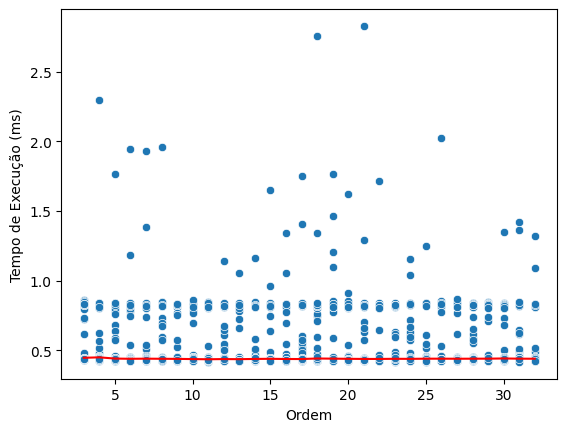

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

df = pd.DataFrame(data = res, columns=['degree', 'size','run', 'runtime'])

sns.scatterplot(data=df, x='degree', y='runtime')

grouped_by_degree = df[['degree', 'runtime']].groupby(by='degree').agg(func='median')
sns.lineplot(data=grouped_by_degree, x='degree', y='runtime', color='r')

plt.ylabel('Tempo de Execução (ms)')
plt.xlabel('Ordem')


Text(0.5, 0, 'Ordem')

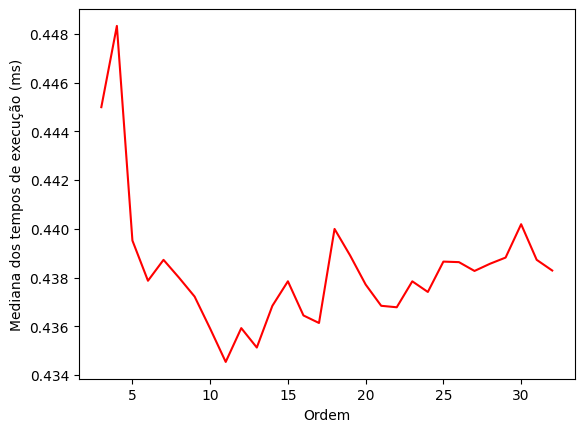

In [ ]:
sns.lineplot(data=grouped_by_degree, x='degree', y='runtime', color='r')

plt.ylabel('Mediana dos tempos de execução (ms)')
plt.xlabel('Ordem')